In [1]:
from PIL import Image
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets import load_dataset
from IPython.display import display
from trainer import trainer
import torchvision.models as models



In [2]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS!")
else:
    device = torch.device("cpu")
    print("Using CPU.")

Using MPS!


In [3]:
def get_pics(base, out_path):
    if base.name.lower().endswith((".jpg", ".jpeg", ".png")):
        image = Image.open(base).convert("RGB")
        image = image.resize((142, 183), resample=Image.LANCZOS)
        if "val" in base.name:
            image.save(f"{out_path}/val/{base.name}")
        else:
            image.save(f"{out_path}/train/{base.name}")
    elif base.is_dir():
        for file in base.iterdir():
            get_pics(file, out_path)

In [4]:
# from pathlib import Path

# get_pics(Path("imagenette2-320"), "content_images")

Shape: torch.Size([3, 183, 142])


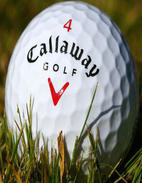

In [5]:
content_image = Image.open("../../content_images/train/n03445777_70.JPEG").convert("RGB")
transform = transforms.ToTensor()
tensor = transform(content_image)

print("Shape:", tensor.shape)  # (C, H, W)
display(content_image)

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Image transformations (resize, tensor, normalize)
style_transform = transforms.Compose([
    transforms.Resize(size=(184,144)),
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize([0.5]*3, [0.5]*3)     # Normalize to [-1, 1]
])

content_transform = transforms.Compose([
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize([0.5]*3, [0.5]*3)     # Normalize to [-1, 1]
])

Shape: torch.Size([3, 184, 144])
Shape: tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [ 0.8510, -0.5059,  0.2000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.8275, -0.5137,  0.0745,  ...,  0.9922,  1.0000,  0.9922],
         [ 0.9137,  0.0275,  0.3098,  ...,  0.9922,  1.0000,  1.0000]],

        [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [ 0.8510, -0.5059,  0.2000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.8275, -0.5137,  0.0745,  ...,  0.9922,  1.0000,  0.9922],
         [ 0.9137,  0.0275,  0.3098,  ...,  0.9922,  1.0000,  1.0000]],

        [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
     

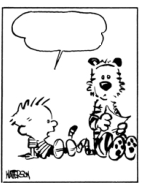

In [7]:
style_image = Image.open("../../OCR_PARSED_PANELS/panel_99.png").convert("RGB")
tensor = style_transform(style_image)

print("Shape:", tensor.shape)  # (C, H, W)
print("Shape:", tensor)  # (C, H, W)
display(style_image)


In [8]:
# Dataset root folder
dataset_path = "../../content_images"

# Load dataset using ImageFolder
dataset = datasets.ImageFolder(root=dataset_path, transform=style_transform)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

In [9]:
# Load pretrained VGG16 features (no classifier)
# vgg16 = models.vgg16(pretrained=True).features.eval()

# # Save model weights
# torch.save(vgg16.state_dict(), "vgg16_features.pth")

In [10]:
from trainer import trainer
tensor = style_transform(style_image)
tr = trainer(tensor, 5, dataloader, device, 1e-4, 1e5)
tr.train()

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 64, 64])) that is different to the input size (torch.Size([16, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 128, 128])) that is different to the input size (torch.Size([16, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([16, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please en

Epoch [1], Batch [1], Content: 8.8615, Style: 48.8913, Total: 57.7528
Epoch [1], Batch [11], Content: 7.5563, Style: 17.6537, Total: 25.2100
Epoch [1], Batch [21], Content: 7.8412, Style: 16.8064, Total: 24.6476
Epoch [1], Batch [31], Content: 7.6692, Style: 16.0107, Total: 23.6799
Epoch [1], Batch [41], Content: 7.2806, Style: 15.2175, Total: 22.4981
Epoch [2], Batch [1], Content: 7.9709, Style: 14.6397, Total: 22.6105
Epoch [2], Batch [11], Content: 7.3851, Style: 13.5406, Total: 20.9257
Epoch [2], Batch [21], Content: 6.9874, Style: 12.1615, Total: 19.1488
Epoch [2], Batch [31], Content: 7.7307, Style: 10.6832, Total: 18.4139
Epoch [2], Batch [41], Content: 7.8253, Style: 9.6363, Total: 17.4616
Epoch [3], Batch [1], Content: 7.7546, Style: 8.3783, Total: 16.1329
Epoch [3], Batch [11], Content: 8.5681, Style: 7.6062, Total: 16.1743
Epoch [3], Batch [21], Content: 6.8172, Style: 7.4677, Total: 14.2849
Epoch [3], Batch [31], Content: 7.7202, Style: 6.6080, Total: 14.3282
Epoch [3], Bat

In [11]:
content_image = Image.open("../../content_images/yorkie.png").convert("RGB")
content_tensor = transform(content_image).unsqueeze(0).to(device)  # shape: (1, 3, H, W
print(content_tensor.shape)
with torch.no_grad():
    output = tr.model.net.forward(content_tensor)  # output shape: (1, 3, H, W)

torch.Size([1, 3, 789, 1184])


In [12]:
import torchvision.transforms.functional as TF

# Unnormalize: [-1, 1] → [0, 1]
output = (output.clamp(-1, 1) + 1) / 2



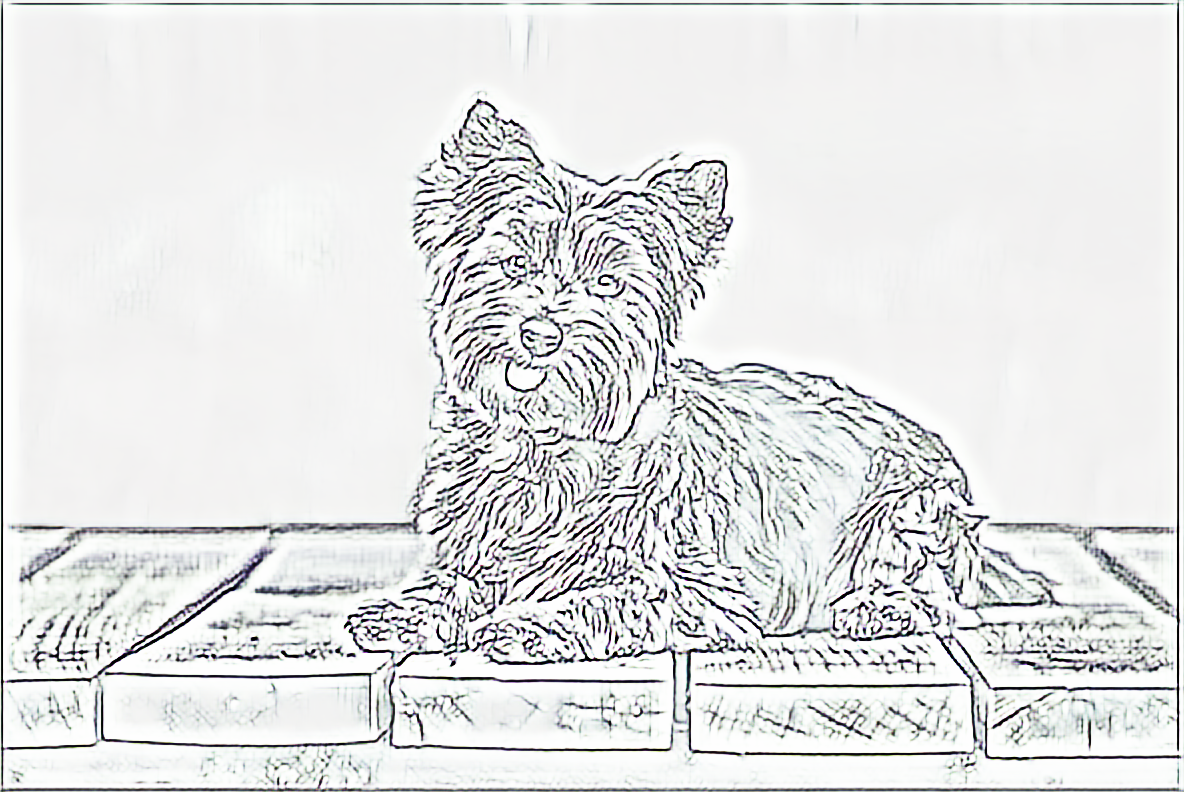

In [13]:
# Convert to PIL and save
stylized_image = TF.to_pil_image(output.squeeze(0).cpu())
display(stylized_image)